In [14]:
#!pip install statsmodels

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

import warnings
warnings.filterwarnings('ignore')


USArrests contiene el porcentaje de asaltos (Assault), asesinatos (Murder) y secuestros (Rape) por cada 100k habitantes para cada uno de los 50 estados de USA (1973). Además, también incluye el porcentaje de la población de cada estado que vive en zonas rurales (UrbanPoP).

In [2]:
USArrests = sm.datasets.get_rdataset("USArrests", "datasets")
datos = USArrests.data
datos.head(4)

,Murder,Assault,UrbanPop,Rape
rownames,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5


Media de cada variable:
- Se muestra que hay 3 veces más secuestros que asesinatos y 8 veces más asaltos que secuestros.

In [3]:
datos.mean(axis=0)

Murder        7.788
Assault     170.760
UrbanPop     65.540
Rape         21.232
dtype: float64

Varianza de cada variable:
- La varianza es muy distinta entre las variables. En el caso de Assault, la varianza es varios órdenes de magnitud superior al resto.

In [4]:
datos.var(axis=0)

Murder        18.970465
Assault     6945.165714
UrbanPop     209.518776
Rape          87.729159
dtype: float64

Si no se estandarizan las variables para que tengan media cero y desviación estándar de uno antes de realizar el estudio PCA, la variable Assault, que tiene una media y dispersión muy superior al resto, dominará la mayoría de las componentes principales.

### PCA

Por defecto, PCA centra los valores pero no los escala. Es necesario escalar las variables.

In [5]:
scaler = StandardScaler()
datos_std = scaler.fit_transform(datos)

pca = PCA()
datos_pca = pca.fit_transform(datos_std)


In [6]:
print(pca.components_)

[[ 0.53589947  0.58318363  0.27819087  0.54343209]
 [-0.41818087 -0.1879856   0.87280619  0.16731864]
 [-0.34123273 -0.26814843 -0.37801579  0.81777791]
 [-0.6492278   0.74340748 -0.13387773 -0.08902432]]


In [7]:
print(pca.explained_variance_ratio_)

[0.62006039 0.24744129 0.0891408  0.04335752]


In [8]:
print(pca.singular_values_)

[11.13607107  7.0347891   4.22234047  2.94474182]


In [9]:
pd.DataFrame(
    data    = pca.components_,
    columns = datos.columns,
    index   = ['PC1', 'PC2', 'PC3', 'PC4']
)

,Murder,Assault,UrbanPop,Rape
PC1,0.535899,0.583184,0.278191,0.543432
PC2,-0.418181,-0.187986,0.872806,0.167319
PC3,-0.341233,-0.268148,-0.378016,0.817778
PC4,-0.649228,0.743407,-0.133878,-0.089024


La primera componente (PC1) es el resultado de la siguiente combinación lineal de las variables originales:

PC1 = 0.535899 * Murder + 0.583184 * Assault + 0.278191 * UrbanPop + 0.543432 * Rape

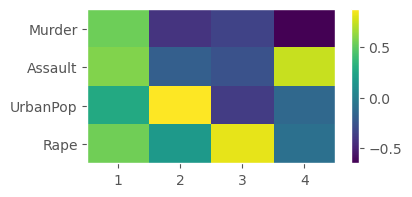

In [10]:
### Heatmap
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 2))
componentes = pca.components_
plt.imshow(componentes.T, cmap='viridis', aspect='auto')
plt.yticks(range(len(datos.columns)), datos.columns)
plt.xticks(range(len(datos.columns)), np.arange(pca.n_components_) + 1)
plt.grid(False)
plt.colorbar()

Es un mapa de calor (heatmap) que muestra las cargas (loadings) de las variables originales en las componentes principales. Indica cómo contribuye cada variable original a cada componente principal.
- Eje vertical: variables originales del dataset.
- Eje horizontal: componentes principales (PC1, PC2, PC3, PC4)

El color representa el valor de la carga (loading):
- amarillo y verde claro -> contribución positiva fuerte
- azul oscuro y morado -> contribución negativa fuerte

UrbanPop en PC2 tiene un color amarillo intenso -> contribuye mucho a la segunda componente

Varianza explicada [0.62006039 0.24744129 0.0891408  0.04335752]


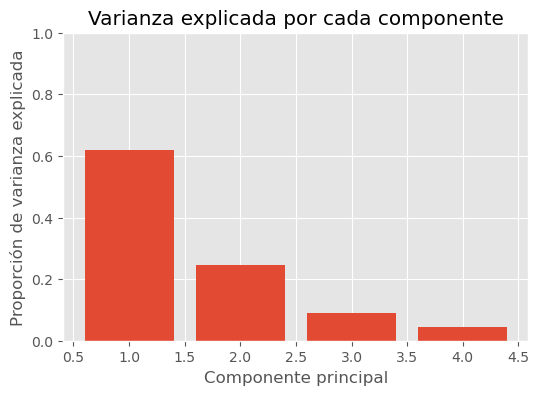

In [11]:
print("Varianza explicada", pca.explained_variance_ratio_)

plt.figure(figsize=(6, 4))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1),
        pca.explained_variance_ratio_)

plt.ylim(0, 1)
plt.xlabel("Componente principal")
plt.ylabel("Proporción de varianza explicada")
plt.title("Varianza explicada por cada componente")

plt.show()


En este caso, la primera componente explica el 62% de la varianza observada en los datos y la segunda el 24.7%.

Porcentaje de varianza explicada acumulada
[0.62006039 0.86750168 0.95664248 1.        ]


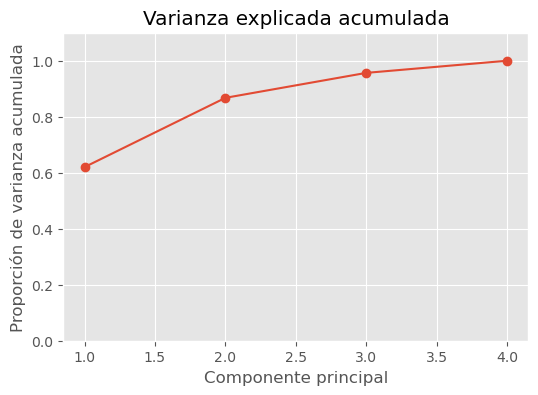

In [12]:
prop_varianza_acum = pca.explained_variance_ratio_.cumsum()

print("Porcentaje de varianza explicada acumulada")
print(prop_varianza_acum)

# Gráfica
plt.figure(figsize=(6, 4))
plt.plot(
    range(1, len(prop_varianza_acum) + 1),
    prop_varianza_acum,
    marker='o'
)

plt.ylim(0, 1.1)
plt.xlabel("Componente principal")
plt.ylabel("Proporción de varianza acumulada")
plt.title("Varianza explicada acumulada")

plt.show()

Si se empleasen únicamente las dos primeras componentes se conseguiría explicar el 87% de la varianza observada.

### Transformación

Una vez entrenado el modelo, con el método transform() se puede reducir la dimensionalidad de nuevas observaciones proyectándolas en el espacio definido por las componentes.

In [13]:
proyecciones = pd.DataFrame(
    datos_pca,
    columns = ['PC1', 'PC2', 'PC3', 'PC4'],
    index   = datos.index
)
proyecciones.head()

,PC1,PC2,PC3,PC4
rownames,,,,
Alabama,0.985566,-1.133392,-0.444269,-0.156267
Alaska,1.950138,-1.073213,2.040003,0.438583
Arizona,1.763164,0.745957,0.054781,0.834653
Arkansas,-0.141420,-1.119797,0.114574,0.182811
California,2.523980,1.542934,0.598557,0.341996


La transformación es el resultado de multiplicar los vectores que definen cada componente con el valor de las variables. Puede calcularse de forma manual:

Z = W * X(centrado)^T

In [14]:
proyecciones = np.dot(pca.components_, scale(datos).T)
proyecciones = pd.DataFrame(proyecciones, index = ['PC1', 'PC2', 'PC3', 'PC4'])
proyecciones = proyecciones.transpose().set_index(datos.index)
proyecciones.head()

,PC1,PC2,PC3,PC4
rownames,,,,
Alabama,0.985566,-1.133392,-0.444269,-0.156267
Alaska,1.950138,-1.073213,2.040003,0.438583
Arizona,1.763164,0.745957,0.054781,0.834653
Arkansas,-0.141420,-1.119797,0.114574,0.182811
California,2.523980,1.542934,0.598557,0.341996


### Reconstrucción

Puede revertirse la transformación y reconstruir el valor inicial con el método inverse_transform(). Es importante tener en cuenta que, la reconstrucción, solo será completa si se han incluido todas las componentes.

In [15]:
# fit: calcula los parámetros del escalado a partir de datos # transform: aplica ese escalado a datos
X_std = scaler.fit_transform(datos)

# proyectar los datos estandarizados X_std a las componentes principales. # Z son las “coordenadas” de los datos en el espacio PCA
Z = pca.transform(X_std)

# inverse_transform hace el camino inverso: desde las componentes Z vuelve a un espacio con el número de variables original, pero todavía en escala estandarizada
X_std_recon = pca.inverse_transform(Z)

# des-escalar: volver a las unidades originales
X_recon = scaler.inverse_transform(X_std_recon)

reconstruccion = pd.DataFrame(
                    X_recon,
                    columns = datos.columns,
                    index   = datos.index
)

print('Valores originales')
display(datos.head())

print('Valores reconstruidos')
display(reconstruccion.head())

Valores originales


,Murder,Assault,UrbanPop,Rape
rownames,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


Valores reconstruidos


,Murder,Assault,UrbanPop,Rape
rownames,,,,
Alabama,13.2,236.0,58.0,21.2
Alaska,10.0,263.0,48.0,44.5
Arizona,8.1,294.0,80.0,31.0
Arkansas,8.8,190.0,50.0,19.5
California,9.0,276.0,91.0,40.6


### Reconstrucción con menos dimensiones


In [16]:
# PCA con menos dimensiones
pca2 = PCA(n_components=2)
datos_pca2 = pca2.fit_transform(datos_std)

# Reconstrucción en espacio estandarizado
datos_std_rec  = pca2.inverse_transform(datos_pca2)

# Volver a la escala original
datos_rec = scaler.inverse_transform(datos_std_rec)

df_original = pd.DataFrame(datos, columns=datos.columns, index=datos.index)
df_reconstruido = pd.DataFrame(datos_rec, columns=datos.columns, index=datos.index)

comparacion = pd.concat(
    [df_original.head(5), df_reconstruido.head(5)],
    axis=1,
    keys=["Original", "Reconstruido"]
)

print(comparacion)


           Original                        Reconstruido              \
             Murder Assault UrbanPop  Rape       Murder     Assault   
rownames                                                              
Alabama        13.2     236       58  21.2    12.108907  235.755815   
Alaska         10.0     263       48  44.5    14.229193  281.230658   
Arizona         8.1     294       80  31.0    10.517042  244.021633   
Arkansas        8.8     190       50  19.5     9.480315  181.322623   
California      9.0     276       91  40.6    10.838010  268.266387   

                                  
             UrbanPop       Rape  
rownames                          
Alabama     55.293753  24.439738  
Alaska      59.891444  29.393422  
Arizona     81.897906  31.273586  
Arkansas    50.971310  18.782131  
California  94.898277  36.343663  
